## Run the Synthetic Dataset through KIF and Compare

Reviewer comment: "Construct a model system with synthetic data where correlated features are known a priori, and show the method works. I would especially like to see a test where duplicate copies of some features are added. Does the method still work?"

**The plan for this notebook is to:**
- Generate all possible KIF results with the synthetic dataset generated.
- Collate results generated
- Evaluate rank ordering ability for each method.
- Duplicate a selection of features and test how each method does. 

### Part 1: Prep datasets

In [1]:
from pathlib import Path
import pandas as pd
import scipy
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from key_interactions_finder import stat_modelling
from key_interactions_finder import model_building
from key_interactions_finder import post_proccessing

In [2]:
# Create the directory to store the final results. 
out_dir_path = Path("KIF_Results")
if not out_dir_path.exists():
    Path.mkdir(out_dir_path)

Load the data back in and create the regression and classification problems.

In [3]:
synth_df = pd.read_csv("Raw/synthetic_data.csv")
synth_df_corr = pd.read_csv("Raw/synthetic_data_correls.csv")
len(synth_df.columns)

38

In [4]:
# Seperate the regression and classification tasks to their own dfs. 
df_regress = synth_df.drop(["Binary_Target"], axis=1)

# Done like this to rename the target column "Target" and place it first in the df. 
df_classif = synth_df.drop(["Target", "Binary_Target"], axis=1)
df_classif.insert(0, "Target", synth_df.pop("Binary_Target"))
df_classif

len(df_classif.columns) == len(df_regress.columns) == 37

True

### Part 2: Run all possible methods available within KIF
Store the per feature scores as I go along. 

### Statistical Analysis - Regression 


In [5]:
regress_stat_model = stat_modelling.RegressionStatModel(
    dataset=df_regress, 
    out_dir="tmp",
    interaction_types_included=["Hbond", "Saltbr", "Hydrophobic", "Other"] 
)

In [6]:
regress_stat_model.scaled_dataset.head(3)

,Target,r2_min_0_05_normal,r2_min_0_15_normal,r2_min_0_25_normal,r2_min_0_35_normal,r2_min_0_45_normal,r2_min_0_55_normal,r2_min_0_65_normal,r2_min_0_75_normal,r2_min_0_85_normal,...,r2_min_0_85_uniform,r2_plus_0_1_uniform,r2_plus_0_2_uniform,r2_plus_0_3_uniform,r2_plus_0_4_uniform,r2_plus_0_5_uniform,r2_plus_0_6_uniform,r2_plus_0_7_uniform,r2_mplus_0_8_uniform,r2_plus_0_9_uniform
0,14.302265,0.607183,0.646249,0.607689,0.607925,0.596903,0.571626,0.545670,0.517547,0.483826,...,0.364100,0.663681,0.678645,0.681627,0.684147,0.686339,0.691904,0.698922,0.705880,0.713841
1,10.950260,0.443368,0.456326,0.486759,0.507487,0.518728,0.517411,0.515842,0.514121,0.512039,...,0.459573,0.507654,0.518914,0.521071,0.522857,0.524453,0.531404,0.540568,0.549743,0.560170
2,12.917100,0.814861,0.838545,0.807008,0.803266,0.784691,0.747347,0.709047,0.667592,0.617864,...,0.397104,0.576100,0.592828,0.598277,0.602811,0.606715,0.614830,0.624598,0.634367,0.645454


In [7]:
regress_stat_model.calc_mutual_info_to_target(save_result=False)
regress_stat_model.calc_linear_correl_to_target(save_result=False)

regress_mi_scores = regress_stat_model.mutual_infos
regress_lc_scores = regress_stat_model.linear_correlations

Mutual information scores calculated.
Linear correlations calculated.


### Statistical Analysis - Classification 


In [8]:
class_stat_model = stat_modelling.ClassificationStatModel(
    dataset=df_classif, 
    class_names=["Class1", "Class2"], 
    out_dir="tmp",
    interaction_types_included=["Hbond", "Saltbr", "Hydrophobic", "Other"] 
)

In [9]:
class_stat_model.calc_js_distances(save_result=False)
class_stat_model.calc_mutual_info_to_target(save_result=False)

class_js_scores = class_stat_model.js_distances
class_mi_scores = class_stat_model.mutual_infos

Jensen-Shannon (JS) distances calculated.
Mutual information scores calculated.


### ML - Regression 

In [10]:
regress_ml_model = model_building.RegressionModel(
    dataset=df_regress,
    evaluation_split_ratio=0.15,
    models_to_use=["CatBoost", "XGBoost", "Random_Forest"], 
    scaling_method="min_max",
    out_dir="tmp", 
    cross_validation_splits=5, 
    cross_validation_repeats=3,
    search_approach="none",
)

regress_ml_model.build_models(save_models=True)


Below is a summary of the machine learning you have planned.
You will use 5-fold cross validation and perform 3 repeats.
You will use up to 37 features to build each model, with 85.0% of your data used for training the model, which is 8500 observations. 
15.0% of your data will be used for evaluating the best models produced by the 5-fold cross validation, which is 1500 observations.
You have selected to build 3 machine learning model(s), with the following hyperparameters: 
 
A CatBoost model, with grid search parameters: 
{'iterations': [100]} 

A XGBoost model, with grid search parameters: 
{'n_estimators': [100]} 

A Random_Forest model, with grid search parameters: 
{'n_estimators': [100], 'max_depth': [100]} 

If you're happy with the above, lets get model building!
Model saved to disk at: temporary_files\CatBoost_Model.pickle
Model saved to disk at: temporary_files\XGBoost_Model.pickle
Model saved to disk at: temporary_files\Random_Forest_Model.pickle
Model building complete, r

,model,best_params,best_score,best_standard_deviation,Time taken to build model (minutes)
0,CatBoost,{'iterations': 100},0.998434,0.000303,0.17
1,XGBoost,{'n_estimators': 100},0.998600,0.000242,0.35
2,Random_Forest,"{'max_depth': 100, 'n_estimators': 100}",0.999531,0.000123,2.70


In [11]:
reports = regress_ml_model.evaluate_models()
reports

Mean Squared Log Error cannot be calculated as your target column contains
                  negative numbers. Continuing with the other metrics.
Mean Squared Log Error cannot be calculated as your target column contains
                  negative numbers. Continuing with the other metrics.
Mean Squared Log Error cannot be calculated as your target column contains
                  negative numbers. Continuing with the other metrics.


,Model,Explained Variance,Mean Absolute Error,MSE,RMSE,Mean Squared Log Error,r squared
0,CatBoost,0.9989,0.0754,0.0101,0.1007,N/A,0.9989
1,XGBoost,0.9989,0.0747,0.0107,0.1036,N/A,0.9989
2,Random_Forest,0.9998,0.0248,0.0023,0.0480,N/A,0.9998


In [12]:
regress_ml_post_proc = post_proccessing.SupervisedPostProcessor(
    out_dir="tmp",
)

regress_ml_post_proc.load_models_from_instance(supervised_model=regress_ml_model)

regress_ml_post_proc.get_per_feature_scores(save_result=False)
regress_ml_scores = regress_ml_post_proc.all_per_feature_scores

All per feature scores have now been saved to disk.


### ML - Classification

In [13]:
# Instantiate the model.
class_ml = model_building.ClassificationModel(
    dataset=df_classif,
    evaluation_split_ratio=0.15,
    classes_to_use=["Class1", "Class2"], 
    models_to_use=["CatBoost", "XGBoost", "Random_Forest"],
    scaling_method="min_max",
    out_dir="tmp", 
    cross_validation_splits=5, 
    cross_validation_repeats=3,
    search_approach="none",
)

class_ml.build_models(save_models=True)


Below is a summary of the machine learning you have planned.
You will use 5-fold cross validation and perform 3 repeats.
You will use up to 37 features to build each model, with 85.0% of your data used for training the model, which is 8500 observations. 
15.0% of your data will be used for evaluating the best models produced by the 5-fold cross validation, which is 1500 observations.
You have selected to build 3 machine learning model(s), with the following hyperparameters: 
 
A CatBoost model, with grid search parameters: 
{'iterations': [100]} 

A XGBoost model, with grid search parameters: 
{'n_estimators': [100]} 

A Random_Forest model, with grid search parameters: 
{'n_estimators': [100], 'max_depth': [100]} 

If you're happy with the above, lets get model building!
Model saved to disk at: temporary_files\CatBoost_Model.pickle
Model saved to disk at: temporary_files\XGBoost_Model.pickle
Model saved to disk at: temporary_files\Random_Forest_Model.pickle
Model building complete, r

,model,best_params,best_score,best_standard_deviation,Time taken to build model (minutes)
0,CatBoost,{'iterations': 100},0.993922,0.001544,0.18
1,XGBoost,{'n_estimators': 100},0.994745,0.001480,0.12
2,Random_Forest,"{'max_depth': 100, 'n_estimators': 100}",0.994784,0.001717,0.37


In [14]:
reports = class_ml.evaluate_models()

print("XGBoost")
print(reports["XGBoost"])

print("CatBoost")
print(reports["CatBoost"])

print("Random_Forest")
print(reports["Random_Forest"])

Returning classification reports for each model inside a single dictionary
XGBoost
             precision    recall f1-score support
Class1        0.993324  0.990679    0.992   751.0
Class2        0.990679  0.993324    0.992   749.0
accuracy           N/A       N/A    0.992    1500
macro avg     0.992002  0.992002    0.992  1500.0
weighted avg  0.992004     0.992    0.992  1500.0
CatBoost
             precision    recall  f1-score support
Class1        0.990716  0.994674  0.992691   751.0
Class2        0.994638  0.990654  0.992642   749.0
accuracy           N/A       N/A  0.992667    1500
macro avg     0.992677  0.992664  0.992667  1500.0
weighted avg  0.992675  0.992667  0.992667  1500.0
Random_Forest
             precision    recall  f1-score support
Class1        0.993369  0.997337  0.995349   751.0
Class2        0.997319  0.993324  0.995318   749.0
accuracy           N/A       N/A  0.995333    1500
macro avg     0.995344  0.995331  0.995333  1500.0
weighted avg  0.995341  0.995333 

In [15]:
class_ml_post_proc = post_proccessing.SupervisedPostProcessor(
    out_dir="tmp",
)
class_ml_post_proc.load_models_from_instance(supervised_model=class_ml)

class_ml_post_proc.get_per_feature_scores(save_result=False)
class_ml_scores = class_ml_post_proc.all_per_feature_scores

All per feature scores have now been saved to disk.


Quick look at shape of the outputted results 

In [16]:
class_ml_scores

{'CatBoost': {'r2_plus_0_9_uniform': 22.54242817,
  'r2_min_0_85_uniform': 17.46043697,
  'r2_plus_0_9_normal': 17.37260246,
  'r2_min_0_75_uniform': 8.00601236,
  'r2_min_0_75_normal': 7.73200374,
  'r2_min_0_85_normal': 5.62761685,
  'r2_mplus_0_8_uniform': 4.94968524,
  'r2_plus_0_6_uniform': 1.74307837,
  'r2_plus_0_7_uniform': 1.38438342,
  'r2_min_0_65_uniform': 1.27149822,
  'r2_min_0_45_uniform': 1.06655537,
  'r2_min_0_55_normal': 1.02012824,
  'r2_min_0_65_normal': 1.01762019,
  'r2_min_0_25_uniform': 0.95920452,
  'r2_mplus_0_8_normal': 0.89895526,
  'r2_plus_0_2_uniform': 0.72981988,
  'r2_min_0_05_uniform': 0.68217165,
  'r2_min_0_05_normal': 0.65961706,
  'r2_min_0_35_uniform': 0.65001183,
  'r2_plus_0_3_uniform': 0.61753552,
  'r2_plus_0_5_normal': 0.55134043,
  'r2_plus_0_7_normal': 0.47600718,
  'r2_plus_0_3_normal': 0.44747176,
  'r2_plus_0_1_uniform': 0.36028038,
  'r2_plus_0_4_uniform': 0.29172736,
  'r2_min_0_15_normal': 0.28936882,
  'r2_min_0_15_uniform': 0.21471

### Part 3 - Collate all the Results Generated

First create a df of the stats and ml results with the real linear correlations (LCs) included for easier comparison/plotting. 

In [17]:
# Need the absolute values of the linear correlation for comparison.
real_correls = dict(synth_df_corr.loc[0][1:])
real_correls_abs = {key: abs(value) for key, value in real_correls.items()} 

regress_lc_scores_abs = {key: abs(value) for key, value in regress_lc_scores.items()} 

In [18]:
stat_columns=["Real_LC", "Real_LC_Abs", 
              "Regress_LC_Abs", "Regress_MI", "Class_JS", "Class_MI"]

stat_df = pd.DataFrame([real_correls, real_correls_abs, regress_lc_scores_abs, regress_mi_scores, class_js_scores, class_mi_scores]).T
stat_df.columns = stat_columns
stat_df.head(3)

,Real_LC,Real_LC_Abs,Regress_LC_Abs,Regress_MI,Class_JS,Class_MI
r2_min_0_05_normal,-0.05,0.05,0.050812,0.00000,0.04402,0.00000
r2_min_0_15_normal,0.15,0.15,0.152384,0.00000,0.10513,0.00320
r2_min_0_25_normal,-0.25,0.25,0.253808,0.01532,0.17435,0.02851


In [19]:
ml_columns=["Regress_CatBoost", "Regress_XGBoost", "Regress_Random_Forest", 
            "Class_CatBoost", "Class_XGBoost", "Class_Random_Forest"]

ml_dicts = [regress_ml_scores["CatBoost"], regress_ml_scores["XGBoost"], regress_ml_scores["Random_Forest"],
            class_ml_scores["CatBoost"], class_ml_scores["XGBoost"], class_ml_scores["Random_Forest"]]

ml_df = pd.DataFrame(ml_dicts).T
ml_df.columns = ml_columns
ml_df.head(3)

,Regress_CatBoost,Regress_XGBoost,Regress_Random_Forest,Class_CatBoost,Class_XGBoost,Class_Random_Forest
r2_plus_0_9_uniform,49.784921,0.578978,0.654639,22.542428,0.011838,0.150563
r2_min_0_85_normal,13.378554,0.051770,0.019806,5.627617,0.206855,0.106721
r2_min_0_85_uniform,11.727590,0.268538,0.277556,17.460437,0.009795,0.094276


In [20]:
all_methods_df = pd.concat([stat_df, ml_df], axis=1)
with pd.option_context("display.max_rows", 6):
    display(all_methods_df)

,Real_LC,Real_LC_Abs,Regress_LC_Abs,Regress_MI,Class_JS,Class_MI,Regress_CatBoost,Regress_XGBoost,Regress_Random_Forest,Class_CatBoost,Class_XGBoost,Class_Random_Forest
r2_min_0_05_normal,-0.05,0.05,0.050812,0.00000,0.04402,0.00000,0.042522,0.000061,0.000018,0.659617,0.037603,0.003205
r2_min_0_15_normal,0.15,0.15,0.152384,0.00000,0.10513,0.00320,1.548763,0.000203,0.000013,0.289369,0.000000,0.002530
r2_min_0_25_normal,-0.25,0.25,0.253808,0.01532,0.17435,0.02851,0.002866,0.000099,0.000020,0.035396,0.022048,0.005122
...,...,...,...,...,...,...,...,...,...,...,...,...
r2_plus_0_7_uniform,0.72,0.72,0.715367,0.70510,0.55846,0.24941,0.001162,0.000472,0.000093,1.384383,0.002704,0.047851
r2_mplus_0_8_uniform,0.81,0.81,0.812278,1.04274,0.64053,0.34958,0.179870,0.000805,0.000289,4.949685,0.010018,0.044718
r2_plus_0_9_uniform,0.91,0.91,0.907211,1.82298,0.74505,0.49749,49.784921,0.578978,0.654639,22.542428,0.011838,0.150563


In [21]:
def min_max_normalise(df:pd.DataFrame) -> pd.DataFrame:
    """
    Perform column wise min-max scaling on all columns except the real linear correlations.  
    Min-max scaling chosen as this makes it easy to plot multiple results on the same graph
    and preserves the datas shape. 
    """
    result = df.copy(deep=True)
    for feature_name in df.columns[3:]: # skip the 3 linear correlation columns. 
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [22]:
all_methods_df_norm = min_max_normalise(all_methods_df)
with pd.option_context("display.max_rows", 6):
    display(all_methods_df_norm)

,Real_LC,Real_LC_Abs,Regress_LC_Abs,Regress_MI,Class_JS,Class_MI,Regress_CatBoost,Regress_XGBoost,Regress_Random_Forest,Class_CatBoost,Class_XGBoost,Class_Random_Forest
r2_min_0_05_normal,-0.05,0.05,0.050812,0.000000,0.000000,0.000000,0.000831,0.000000,0.000007,0.028913,0.086199,0.009017
r2_min_0_15_normal,0.15,0.15,0.152384,0.000000,0.087172,0.006432,0.031086,0.000246,0.000000,0.012483,0.000000,0.004647
r2_min_0_25_normal,-0.25,0.25,0.253808,0.008404,0.185912,0.057308,0.000034,0.000066,0.000010,0.001212,0.050542,0.021442
...,...,...,...,...,...,...,...,...,...,...,...,...
r2_plus_0_7_uniform,0.72,0.72,0.715367,0.386784,0.733835,0.501337,0.000000,0.000710,0.000122,0.061076,0.006200,0.298260
r2_mplus_0_8_uniform,0.81,0.81,0.812278,0.571997,0.850905,0.702687,0.003590,0.001286,0.000421,0.219292,0.022965,0.277967
r2_plus_0_9_uniform,0.91,0.91,0.907211,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.027137,0.963687


### Part 4. Compare KIF Per Feature Scores to the Known Feature Correlations

I will measure the ability of each method to rank order (Spearman's rank) the feature correlations.

In some cases, the absolute values will need to be taken for proper comparisons.

In [23]:
methods = stat_columns[2:] + ml_columns
print(methods)

['Regress_LC_Abs', 'Regress_MI', 'Class_JS', 'Class_MI', 'Regress_CatBoost', 'Regress_XGBoost', 'Regress_Random_Forest', 'Class_CatBoost', 'Class_XGBoost', 'Class_Random_Forest']


In [24]:
spearmans_ranks = {}
for method in methods:
    if method == "Regress_LC":
        real_values = "Real_LC"
    else:
        real_values = "Real_LC_Abs"

    spearman = scipy.stats.spearmanr(all_methods_df_norm[real_values], all_methods_df_norm[method])[0]
    spearmans_ranks.update({method: round(spearman, 2)})

In [25]:
spearmans_ranks

{'Regress_LC_Abs': 1.0,
 'Regress_MI': 0.94,
 'Class_JS': 0.99,
 'Class_MI': 0.98,
 'Regress_CatBoost': 0.26,
 'Regress_XGBoost': 0.61,
 'Regress_Random_Forest': 0.78,
 'Class_CatBoost': 0.65,
 'Class_XGBoost': 0.45,
 'Class_Random_Forest': 0.98}

Save all the per feature scores for later use.

In [26]:
all_methods_df_norm.to_csv(r"KIF_Results/all_feature_scores.csv", index=True)

In [27]:
all_methods_df_norm.columns

Index(['Real_LC', 'Real_LC_Abs', 'Regress_LC_Abs', 'Regress_MI', 'Class_JS',
       'Class_MI', 'Regress_CatBoost', 'Regress_XGBoost',
       'Regress_Random_Forest', 'Class_CatBoost', 'Class_XGBoost',
       'Class_Random_Forest'],
      dtype='object')

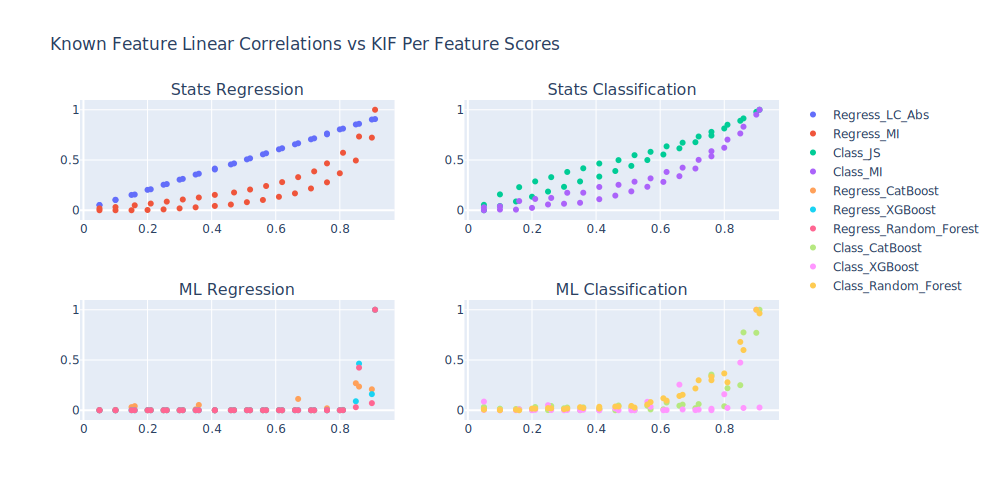

In [28]:
# quick scatter plot to visualise the results. 
def add_subplot(columns, plot_pos):
    """Helper function to add a plotly subplot."""
    for column in columns:
        fig.add_trace(
            go.Scatter(x=all_methods_df_norm["Real_LC_Abs"], 
                       y=all_methods_df_norm[column],
                       name=column,
                       mode="markers"),
            row=plot_pos[0], col=plot_pos[1]
        )


# Make the subplot and add all the results in. 
fig = make_subplots(rows=2, cols=2, 
                    subplot_titles=("Stats Regression", "Stats Classification", "ML Regression", "ML Classification"))


stats_regress_columns = ["Regress_LC_Abs", "Regress_MI"]
stats_classif_columns = ["Class_JS", "Class_MI"]
ml_regress_columns = ["Regress_CatBoost", "Regress_XGBoost", "Regress_Random_Forest"]
ml_classif_columns = ["Class_CatBoost", "Class_XGBoost", "Class_Random_Forest"]

add_subplot(columns=stats_regress_columns, plot_pos=[1,1])
add_subplot(columns=stats_classif_columns, plot_pos=[1,2])
add_subplot(columns=ml_regress_columns, plot_pos=[2,1])
add_subplot(columns=ml_classif_columns, plot_pos=[2,2])

fig.update_layout(title_text="Known Feature Linear Correlations vs KIF Per Feature Scores", width=1000)
fig.show("svg")

The above figure shows the stats methods are correctly able to rank order the features. In contrast, the ML methods only identify some of the important features leaving others alone. This is expected behavior given the nature of the problem the ML methods are trying to solve (obtain good accuracy using as many features as needed, not as many features as possible).

### Part 5: Prep For Effect of Duplication on Methods 

Will duplicate some features and run the calculations through KIF again. 

In [29]:
df_classif.head(2)

,Target,r2_min_0_05_normal,r2_min_0_15_normal,r2_min_0_25_normal,r2_min_0_35_normal,r2_min_0_45_normal,r2_min_0_55_normal,r2_min_0_65_normal,r2_min_0_75_normal,r2_min_0_85_normal,...,r2_min_0_85_uniform,r2_plus_0_1_uniform,r2_plus_0_2_uniform,r2_plus_0_3_uniform,r2_plus_0_4_uniform,r2_plus_0_5_uniform,r2_plus_0_6_uniform,r2_plus_0_7_uniform,r2_mplus_0_8_uniform,r2_plus_0_9_uniform
0,Class1,13.981,14.982,14.985,15.265,15.378,15.299,14.983,14.349,13.222,...,7.921,7.631,8.952,10.206,11.389,12.490,13.726,14.980,16.099,16.983
1,Class1,10.209,10.579,12.003,12.743,13.364,13.848,14.164,14.254,13.993,...,9.998,5.837,6.845,7.802,8.704,9.544,10.542,11.586,12.538,13.327


In [30]:
# Selection of five columns with diff properties to duplicate. 
to_duplicate = ["r2_plus_0_1_normal", "r2_plus_0_3_uniform", "r2_min_0_65_normal", "r2_min_0_75_uniform", "r2_plus_0_9_normal"]

df_classif_dupl = df_classif.copy(deep=True)
for duplicate in to_duplicate:
    duplicate_name = "dupl_" + duplicate
    df_classif_dupl[duplicate_name] = df_classif[duplicate]

len(df_classif_dupl.columns)
df_classif_dupl["dupl_r2_plus_0_1_normal"].equals(df_classif["r2_plus_0_1_normal"]) # sanity check

True

In [31]:
# As above but for regression
df_regress_dupl = df_regress.copy(deep=True)
for duplicate in to_duplicate:
    duplicate_name = "dupl_" + duplicate
    df_regress_dupl[duplicate_name] = df_regress[duplicate]

len(df_classif_dupl.columns)
df_regress_dupl["dupl_r2_plus_0_1_normal"].equals(df_regress["r2_plus_0_1_normal"]) # sanity check

True

## Part 6: Run the regression and classification again for the Stats and ML methods in KIF.

In [32]:
# Stats - regression 
regress_stat_model_dupl = stat_modelling.RegressionStatModel(
    dataset=df_regress_dupl, 
    out_dir="tmp",
    interaction_types_included=["Hbond", "Saltbr", "Hydrophobic", "Other"] 
)

regress_stat_model_dupl.calc_mutual_info_to_target(save_result=False)
regress_stat_model_dupl.calc_linear_correl_to_target(save_result=False)

regress_mi_scores_dupl = regress_stat_model_dupl.mutual_infos
regress_lc_scores_dupl = regress_stat_model_dupl.linear_correlations

Mutual information scores calculated.
Linear correlations calculated.


In [33]:
# Stats - classification
class_stat_model_dupl = stat_modelling.ClassificationStatModel(
    dataset=df_classif_dupl, 
    class_names=["Class1", "Class2"], 
    out_dir="tmp",
    interaction_types_included=["Hbond", "Saltbr", "Hydrophobic", "Other"] 
)

class_stat_model_dupl.calc_js_distances(save_result=False)
class_stat_model_dupl.calc_mutual_info_to_target(save_result=False)

class_js_scores_dupl = class_stat_model_dupl.js_distances
class_mi_scores_dupl = class_stat_model_dupl.mutual_infos

Jensen-Shannon (JS) distances calculated.
Mutual information scores calculated.


In [34]:
# ML - regression
regress_ml_model_dupl = model_building.RegressionModel(
    dataset=df_regress_dupl,
    evaluation_split_ratio=0.15,
    models_to_use=["CatBoost", "XGBoost", "Random_Forest"], 
    scaling_method="min_max",
    out_dir="tmp", 
    cross_validation_splits=5, 
    cross_validation_repeats=3,
    search_approach="none",
)

regress_ml_model_dupl.build_models(save_models=True)

reports_dupl = regress_ml_model_dupl.evaluate_models()
display(reports_dupl)

regress_ml_post_proc_dupl = post_proccessing.SupervisedPostProcessor(
    out_dir="tmp",
)

regress_ml_post_proc_dupl.load_models_from_instance(supervised_model=regress_ml_model_dupl)

regress_ml_post_proc_dupl.get_per_feature_scores(save_result=False)
regress_ml_scores_dupl = regress_ml_post_proc_dupl.all_per_feature_scores


Below is a summary of the machine learning you have planned.
You will use 5-fold cross validation and perform 3 repeats.
You will use up to 42 features to build each model, with 85.0% of your data used for training the model, which is 8500 observations. 
15.0% of your data will be used for evaluating the best models produced by the 5-fold cross validation, which is 1500 observations.
You have selected to build 3 machine learning model(s), with the following hyperparameters: 
 
A CatBoost model, with grid search parameters: 
{'iterations': [100]} 

A XGBoost model, with grid search parameters: 
{'n_estimators': [100]} 

A Random_Forest model, with grid search parameters: 
{'n_estimators': [100], 'max_depth': [100]} 

If you're happy with the above, lets get model building!
Model saved to disk at: temporary_files\CatBoost_Model.pickle
Model saved to disk at: temporary_files\XGBoost_Model.pickle
Model saved to disk at: temporary_files\Random_Forest_Model.pickle
Model building complete, r

,Model,Explained Variance,Mean Absolute Error,MSE,RMSE,Mean Squared Log Error,r squared
0,CatBoost,0.9989,0.0737,0.0097,0.0987,N/A,0.9989
1,XGBoost,0.9989,0.0721,0.0093,0.0966,N/A,0.9989
2,Random_Forest,0.9998,0.0233,0.0021,0.0461,N/A,0.9998


All per feature scores have now been saved to disk.


In [35]:
# ML - classification
class_ml_dupl = model_building.ClassificationModel(
    dataset=df_classif_dupl,
    evaluation_split_ratio=0.15,
    classes_to_use=["Class1", "Class2"], 
    models_to_use=["CatBoost", "XGBoost", "Random_Forest"],
    scaling_method="min_max",
    out_dir="tmp", 
    cross_validation_splits=5, 
    cross_validation_repeats=3,
    search_approach="none",
)
class_ml_dupl.build_models(save_models=True)

reports_dupl = class_ml_dupl.evaluate_models()
display("XGBoost")
display(reports_dupl["XGBoost"])

display("CatBoost")
display(reports_dupl["CatBoost"])

display("Random_Forest")
display(reports_dupl["Random_Forest"])

class_ml_post_proc_dupl = post_proccessing.SupervisedPostProcessor(
    out_dir="tmp",
)
class_ml_post_proc_dupl.load_models_from_instance(supervised_model=class_ml_dupl)

class_ml_post_proc_dupl.get_per_feature_scores(save_result=False)
class_ml_scores_dupl = class_ml_post_proc_dupl.all_per_feature_scores


Below is a summary of the machine learning you have planned.
You will use 5-fold cross validation and perform 3 repeats.
You will use up to 42 features to build each model, with 85.0% of your data used for training the model, which is 8500 observations. 
15.0% of your data will be used for evaluating the best models produced by the 5-fold cross validation, which is 1500 observations.
You have selected to build 3 machine learning model(s), with the following hyperparameters: 
 
A CatBoost model, with grid search parameters: 
{'iterations': [100]} 

A XGBoost model, with grid search parameters: 
{'n_estimators': [100]} 

A Random_Forest model, with grid search parameters: 
{'n_estimators': [100], 'max_depth': [100]} 

If you're happy with the above, lets get model building!
Model saved to disk at: temporary_files\CatBoost_Model.pickle
Model saved to disk at: temporary_files\XGBoost_Model.pickle
Model saved to disk at: temporary_files\Random_Forest_Model.pickle
Model building complete, r

'XGBoost'

,precision,recall,f1-score,support
Class1,0.997312,0.993307,0.995305,747.0
Class2,0.993386,0.997344,0.995361,753.0
accuracy,N/A,N/A,0.995333,1500
macro avg,0.995349,0.995325,0.995333,1500.0
weighted avg,0.995341,0.995333,0.995333,1500.0


'CatBoost'

,precision,recall,f1-score,support
Class1,0.994624,0.990629,0.992622,747.0
Class2,0.990741,0.994688,0.99271,753.0
accuracy,N/A,N/A,0.992667,1500
macro avg,0.992682,0.992659,0.992666,1500.0
weighted avg,0.992674,0.992667,0.992667,1500.0


'Random_Forest'

,precision,recall,f1-score,support
Class1,0.998649,0.98929,0.993948,747.0
Class2,0.989474,0.998672,0.994052,753.0
accuracy,N/A,N/A,0.994,1500
macro avg,0.994061,0.993981,0.994,1500.0
weighted avg,0.994043,0.994,0.994,1500.0


All per feature scores have now been saved to disk.


### Part 6: Analyse the Impact of Duplication on each Methods 

Now extract the results generated and compare the duplicated feature score to the original feature score. In the ideal scenario, each feature's score and it's corresponding duplicated feature's score should be identical. 

In [36]:
stat_dupl_columns =["Real_LC", "Real_LC_Abs", 
              "Regress_LC_Abs", "Regress_MI", "Class_JS", "Class_MI"]

stat_dupl_df = pd.DataFrame([real_correls, real_correls_abs, regress_lc_scores_dupl, 
                       regress_mi_scores_dupl, class_js_scores_dupl, class_mi_scores_dupl]).T
stat_dupl_df.columns = stat_dupl_columns
stat_dupl_df.head(3)

,Real_LC,Real_LC_Abs,Regress_LC_Abs,Regress_MI,Class_JS,Class_MI
r2_min_0_05_normal,-0.05,0.05,-0.050812,0.00000,0.04402,0.00000
r2_min_0_15_normal,0.15,0.15,0.152384,0.00000,0.10513,0.00468
r2_min_0_25_normal,-0.25,0.25,-0.253808,0.01517,0.17435,0.02826


In [37]:
ml_dupl_columns=["Regress_CatBoost", "Regress_XGBoost", "Regress_Random_Forest", 
            "Class_CatBoost", "Class_XGBoost", "Class_Random_Forest"]

ml_dupl_dicts = [regress_ml_scores_dupl["CatBoost"], regress_ml_scores_dupl["XGBoost"], regress_ml_scores_dupl["Random_Forest"],
            class_ml_scores_dupl["CatBoost"], class_ml_scores_dupl["XGBoost"], class_ml_scores_dupl["Random_Forest"]]

ml_dupl_df = pd.DataFrame(ml_dupl_dicts).T
ml_dupl_df.columns = ml_dupl_columns
ml_dupl_df.head(3)

,Regress_CatBoost,Regress_XGBoost,Regress_Random_Forest,Class_CatBoost,Class_XGBoost,Class_Random_Forest
dupl_r2_plus_0_9_normal,26.097737,0.000000,0.034341,20.126953,0.000000,0.131869
r2_min_0_85_normal,13.473330,0.083184,0.023917,10.851526,0.152244,0.086596
r2_plus_0_9_uniform,12.937112,0.498665,0.651109,14.871121,0.017509,0.099281


In [38]:
# merge dfs and min max normalise the scores for easier plotting. 
all_methods_dupl_df = pd.concat([stat_dupl_df, ml_dupl_df], axis=1)
all_methods_dupl_df_norm = min_max_normalise(all_methods_dupl_df)

with pd.option_context("display.max_rows", 6):
    display(all_methods_dupl_df_norm)

,Real_LC,Real_LC_Abs,Regress_LC_Abs,Regress_MI,Class_JS,Class_MI,Regress_CatBoost,Regress_XGBoost,Regress_Random_Forest,Class_CatBoost,Class_XGBoost,Class_Random_Forest
r2_min_0_05_normal,-0.05,0.05,-0.050812,0.000000,0.000000,0.000000,0.000236,0.000125,0.000009,0.013218,0.123530,0.015535
r2_min_0_15_normal,0.15,0.15,0.152384,0.000000,0.087172,0.009410,0.000612,0.000280,0.000000,0.007505,0.018592,0.009571
r2_min_0_25_normal,-0.25,0.25,-0.253808,0.008320,0.185912,0.056821,0.000000,0.000160,0.000010,0.101603,0.000000,0.016968
...,...,...,...,...,...,...,...,...,...,...,...,...
dupl_r2_min_0_65_normal,NaN,NaN,-0.656044,0.167729,0.615708,0.340565,0.007730,0.000000,0.000018,0.039718,0.000000,0.164165
dupl_r2_plus_0_3_uniform,NaN,NaN,0.312065,0.106742,0.381039,0.168573,0.004543,0.000000,0.000020,0.000291,0.000000,0.018114
dupl_r2_plus_0_1_normal,NaN,NaN,0.101612,0.000000,0.042052,0.006293,0.000648,0.000000,0.000001,0.002537,0.000000,0.001269


Now compare the score between the duplicated columns to see if come out identical 

In [39]:
# previously defined
to_duplicate

['r2_plus_0_1_normal',
 'r2_plus_0_3_uniform',
 'r2_min_0_65_normal',
 'r2_min_0_75_uniform',
 'r2_plus_0_9_normal']

In [40]:
methods = stat_dupl_columns[2:] + ml_dupl_columns
methods

['Regress_LC_Abs',
 'Regress_MI',
 'Class_JS',
 'Class_MI',
 'Regress_CatBoost',
 'Regress_XGBoost',
 'Regress_Random_Forest',
 'Class_CatBoost',
 'Class_XGBoost',
 'Class_Random_Forest']

In [41]:
# Extract each duplicated feature's score in both the original and duplicate."""
method_results = {}
for method in methods:
    duplicated_method = "dupl_" + method
    ori_values, dupl_values = [], []
    
    for duplicate in to_duplicate:
        duplicate_name = "dupl_" + duplicate

        ori_value = round(all_methods_dupl_df_norm[method][duplicate], 3)
        dupl_value = round(all_methods_dupl_df_norm[method][duplicate_name], 3)

        ori_values.append(ori_value)
        dupl_values.append(dupl_value)

    
    method_results.update({method: ori_values})
    method_results.update({duplicated_method: dupl_values})

method_results

{'Regress_LC_Abs': [0.102, 0.312, -0.656, -0.764, 0.903],
 'dupl_Regress_LC_Abs': [0.102, 0.312, -0.656, -0.764, 0.903],
 'Regress_MI': [0.0, 0.107, 0.168, 0.466, 0.722],
 'dupl_Regress_MI': [0.0, 0.107, 0.168, 0.466, 0.722],
 'Class_JS': [0.042, 0.381, 0.616, 0.78, 0.979],
 'dupl_Class_JS': [0.042, 0.381, 0.616, 0.78, 0.979],
 'Class_MI': [0.006, 0.17, 0.345, 0.583, 0.952],
 'dupl_Class_MI': [0.006, 0.169, 0.341, 0.581, 0.954],
 'Regress_CatBoost': [0.001, 0.001, 0.001, 0.14, 0.369],
 'dupl_Regress_CatBoost': [0.001, 0.005, 0.008, 0.119, 1.0],
 'Regress_XGBoost': [0.0, 0.0, 0.001, 0.001, 0.319],
 'dupl_Regress_XGBoost': [0.0, 0.0, 0.0, 0.0, 0.0],
 'Regress_Random_Forest': [0.0, 0.0, 0.0, 0.0, 0.029],
 'dupl_Regress_Random_Forest': [0.0, 0.0, 0.0, 0.0, 0.053],
 'Class_CatBoost': [0.041, 0.049, 0.046, 0.07, 0.429],
 'dupl_Class_CatBoost': [0.003, 0.0, 0.04, 0.117, 1.0],
 'Class_XGBoost': [0.0, 0.0, 0.08, 0.034, 1.0],
 'dupl_Class_XGBoost': [0.0, 0.0, 0.0, 0.0, 0.0],
 'Class_Random_Fores

In [42]:
dupl_compare_df = pd.DataFrame(method_results)
dupl_compare_df 

,Regress_LC_Abs,dupl_Regress_LC_Abs,Regress_MI,dupl_Regress_MI,Class_JS,dupl_Class_JS,Class_MI,dupl_Class_MI,Regress_CatBoost,dupl_Regress_CatBoost,Regress_XGBoost,dupl_Regress_XGBoost,Regress_Random_Forest,dupl_Regress_Random_Forest,Class_CatBoost,dupl_Class_CatBoost,Class_XGBoost,dupl_Class_XGBoost,Class_Random_Forest,dupl_Class_Random_Forest
0,0.102,0.102,0.000,0.000,0.042,0.042,0.006,0.006,0.001,0.001,0.000,0.0,0.000,0.000,0.041,0.003,0.000,0.0,0.004,0.001
1,0.312,0.312,0.107,0.107,0.381,0.381,0.170,0.169,0.001,0.005,0.000,0.0,0.000,0.000,0.049,0.000,0.000,0.0,0.015,0.018
2,-0.656,-0.656,0.168,0.168,0.616,0.616,0.345,0.341,0.001,0.008,0.001,0.0,0.000,0.000,0.046,0.040,0.080,0.0,0.138,0.164
3,-0.764,-0.764,0.466,0.466,0.780,0.780,0.583,0.581,0.140,0.119,0.001,0.0,0.000,0.000,0.070,0.117,0.034,0.0,0.207,0.205
4,0.903,0.903,0.722,0.722,0.979,0.979,0.952,0.954,0.369,1.000,0.319,0.0,0.029,0.053,0.429,1.000,1.000,0.0,1.000,0.928


In [43]:
# Save results 
dupl_compare_df.to_csv("KIF_Results/duplicate_features.csv", index=False)

In [44]:
# Values to compare are in neighbouring columns, using this to obtain them. 
column_combos = []
for idx in range(0, 19, 2):
    column_combos.append(list(dupl_compare_df.iloc[:, idx: idx+2].columns))

column_combos

[['Regress_LC_Abs', 'dupl_Regress_LC_Abs'],
 ['Regress_MI', 'dupl_Regress_MI'],
 ['Class_JS', 'dupl_Class_JS'],
 ['Class_MI', 'dupl_Class_MI'],
 ['Regress_CatBoost', 'dupl_Regress_CatBoost'],
 ['Regress_XGBoost', 'dupl_Regress_XGBoost'],
 ['Regress_Random_Forest', 'dupl_Regress_Random_Forest'],
 ['Class_CatBoost', 'dupl_Class_CatBoost'],
 ['Class_XGBoost', 'dupl_Class_XGBoost'],
 ['Class_Random_Forest', 'dupl_Class_Random_Forest']]

In [45]:
column_combos[2:4]

[['Class_JS', 'dupl_Class_JS'], ['Class_MI', 'dupl_Class_MI']]

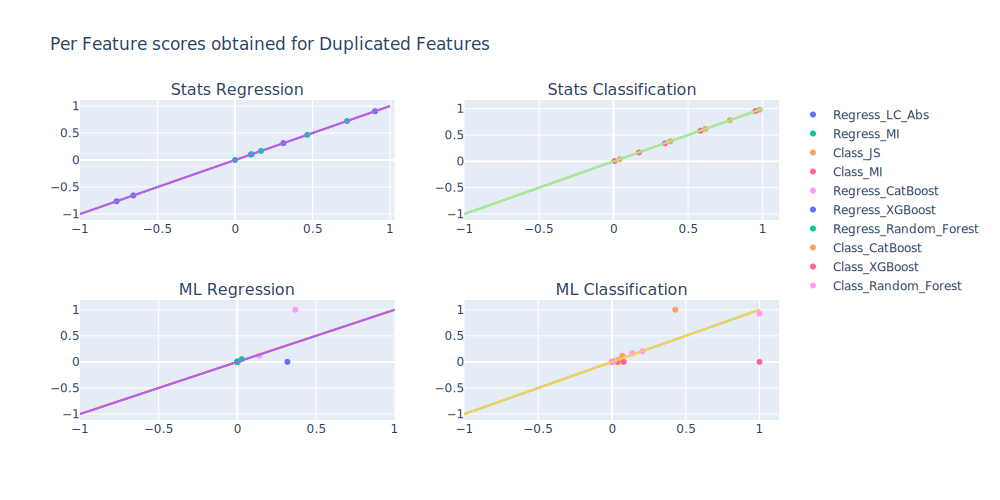

In [46]:
# Quick plot to evaluate the outcomes. 

def add_subplot(pair, plot_pos):
    """Helper function to add a plotly subplot."""
    x_col, y_col = pair[0], pair[1]
    fig.add_trace(
        go.Scatter(x=dupl_compare_df[x_col], 
                    y=dupl_compare_df[y_col],
                    name=x_col,
                    mode="markers"),
        row=plot_pos[0], col=plot_pos[1]
    )

    fig.add_trace(
        go.Scatter(x=[-1, 0, 1], y=[-1, 0, 1], mode="lines", showlegend=False),
        row=plot_pos[0], col=plot_pos[1],
        
    )

# Make the subplot and add all the results in. 
fig = make_subplots(rows=2, cols=2, 
                    subplot_titles=("Stats Regression", "Stats Classification", "ML Regression", "ML Classification"))


# Generate the subplots for the plot.  
for pair in column_combos[0:2]:
    add_subplot(pair=pair, plot_pos=(1,1))

for pair in column_combos[2:4]:
    add_subplot(pair=pair, plot_pos=(1,2))

for pair in column_combos[4:7]:
    add_subplot(pair=pair, plot_pos=(2,1))

for pair in column_combos[7:]:
    add_subplot(pair=pair, plot_pos=(2,2))


fig.update_layout(title_text="Per Feature scores obtained for Duplicated Features", width=1000)
fig.show("svg")

The graph above plots the per feature score obtained for the original and duplicated feature for each method available within KIF. In the ideal scenario, the per feature scores would be identical between the original and duplicated feature (which is a line of the form y=x is drawn for each graph to validate if that is the case). Clearly the stats methods are able to do this whilst the ML methods fail in this context (which was expected).  